# Regularization, LASSO, Ridge, and Cross Validation
- Overfitting, Bias–Variance Tradeoff, Regularization, Lasso, Ridge, Cross validation
- https://harvard-iacs.github.io/2018-CS109A/labs/lab-5/solutions/

In [99]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
#pd.set_option('display.width', 500)
#pd.set_option('display.max_columns', 100)

import seaborn as sns
sns.set()
sns.set_context("poster")

In [7]:
df = pd.read_csv("./data/noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


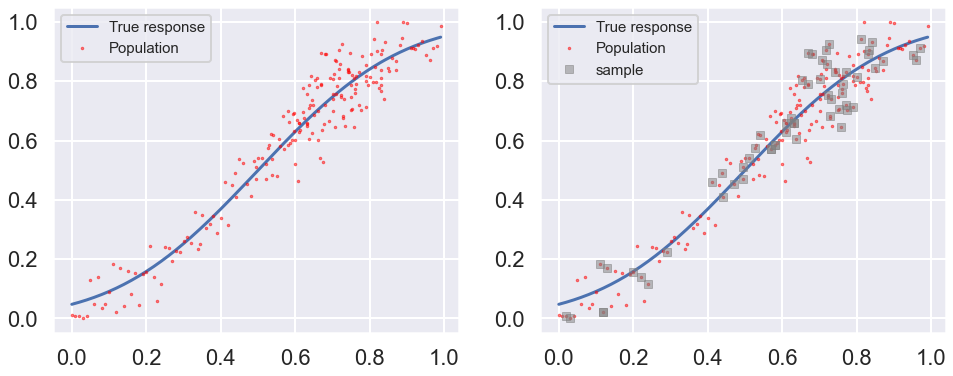

In [88]:
plt.figure(figsize=(16,6))

# Subplot 1
plt.subplot(1,2,1)

x = df.x
y = df.y
f = df.f  

plt.plot(x, f, label = 'True response')
plt.plot(x, y, '.', color = 'red', alpha = 0.5, markersize = 5, label = 'Population')
plt.legend(loc = 'upper left', prop={'size': 15})      

# Subplot 2
plt.subplot(1,2,2)

# Lets take a sample set of 60 from these 200 observed values. 
# Create a random index array of 60 values between 0 and 200 
# Use that to get a subset of the dataframe to create sample_df
index = np.sort(np.random.randint(0, 200, size = 60))
sample_df = df.iloc[index,]
sample_df = sample_df.reset_index(drop = True) # reset index from 0 to n

plt.plot(x, f, label = 'True response')
plt.plot(x, y, '.', color = 'red', alpha = 0.5, markersize = 5, label = 'Population')
plt.plot(sample_df.x, sample_df.y, 's', color = 'gray', alpha = 0.5, markersize = 8, label = 'sample')

plt.legend(loc = 'upper left', prop={'size': 15}) 


## Simple Regression

In [96]:
# split into train and test

from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(np.arange(0,60), random_state=1, train_size = 0.8)

xtrain = sample_df.x[itrain].values
ytrain = sample_df.y[itrain].values
ftrain = sample_df.f[itrain].values

xtest = sample_df.x[itest].values
ytest = sample_df.y[itest].values
ftest = sample_df.f[itest].values


In [170]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept = True)
linreg.fit(xtrain.reshape(-1,1), ytrain)

ypred_linreg = linreg.predict(x.values.reshape(-1,1)) # predict on all x
coef_linreg = (linreg.intercept_, linreg.coef_[0]) # save coeffs


## Ridge Regression for simple regression
The penalty, lambda, is penalizes the square of the coefficients for Ridge, and penalizes absolute value of coeff in LASSO

In [171]:
from sklearn.linear_model import Ridge

# the lambda value is given by alpha.... we start with 0, which is equivalent to simple regression
ridge_reg = Ridge(alpha = 0)  
ridge_reg.fit(xtrain.reshape(-1,1), ytrain)

ypred_ridge = ridge_reg.predict(x.values.reshape(-1,1))
coef_ridge = (ridge_reg.intercept_,ridge_reg.coef_[0]) # save coeffs

In [358]:
compare_coef = pd.DataFrame(list(zip(coef_linreg, coef_ridge)),
               columns =['OLS', 'Ridge (l = 0)'])
compare_coef.index = ['beta_0', 'beta_1']
compare_coef

,OLS,Ridge (l = 0)
beta_0,-0.035993,-0.035993
beta_1,1.096268,1.096268


## Explore Ridge for multiple lambda values
We can see that as the cost penalty (lambda) increases, the value of the coefficient decreases. For very large lambda values, the coefficient is practically zero and hence the slope is 0, leading to a horizontal line

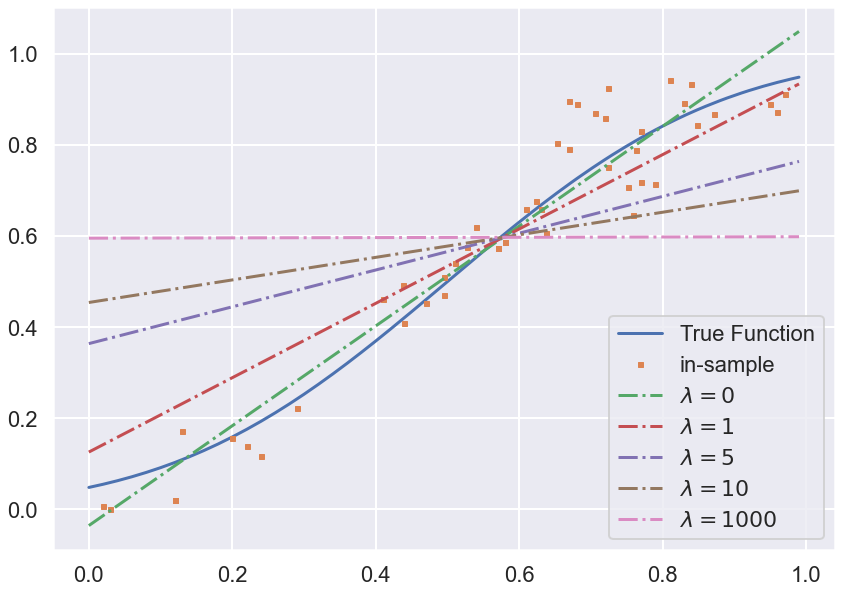

In [194]:
plt.figure(figsize=(14,10))
plt.plot(x, f, '-', label = 'True Function') # actual function
plt.plot(xtrain, ytrain, 's', markersize = 5, label = 'in-sample') # in-sample training data


alpha = [0,1,5,10,1000]

for i in alpha:
    
    ridge_reg = Ridge(alpha = i)  
    ridge_reg.fit(xtrain.reshape(-1,1), ytrain)
    ypred_ridge = ridge_reg.predict(x.values.reshape(-1,1))

    plt.plot(x, ypred_ridge, '-.', markersize = 5, label = r"$\lambda = {}$".format(i))

plt.legend(loc = 'lower right')



##  Ridge with Polynomial Features
Take a 1D vector x and get 1 + x + x^2 + x^3 + x^4, and use this to prect y

In [206]:
# show how to convert array into a polynomial
from sklearn.preprocessing import PolynomialFeatures

toy = np.array([0, 2, 5])
PolynomialFeatures(4).fit_transform(toy.reshape(-1,1))

array([[  1.,   0.,   0.,   0.,   0.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   5.,  25., 125., 625.]])

- ```xtrain and ytrain``` are the test set data. 
- xtrain converted to polynomial degree ```xtrain_poly``` using the polynomialfeatures function
- Ridge is then used with various lambdas to fit ```(xtrain_poly, ytrain)```
- Ridge model is then used to predict the new ```Ys``` based on new values ```new_xtest_poly```  which is a polynomial transformation of ```new_xtest```

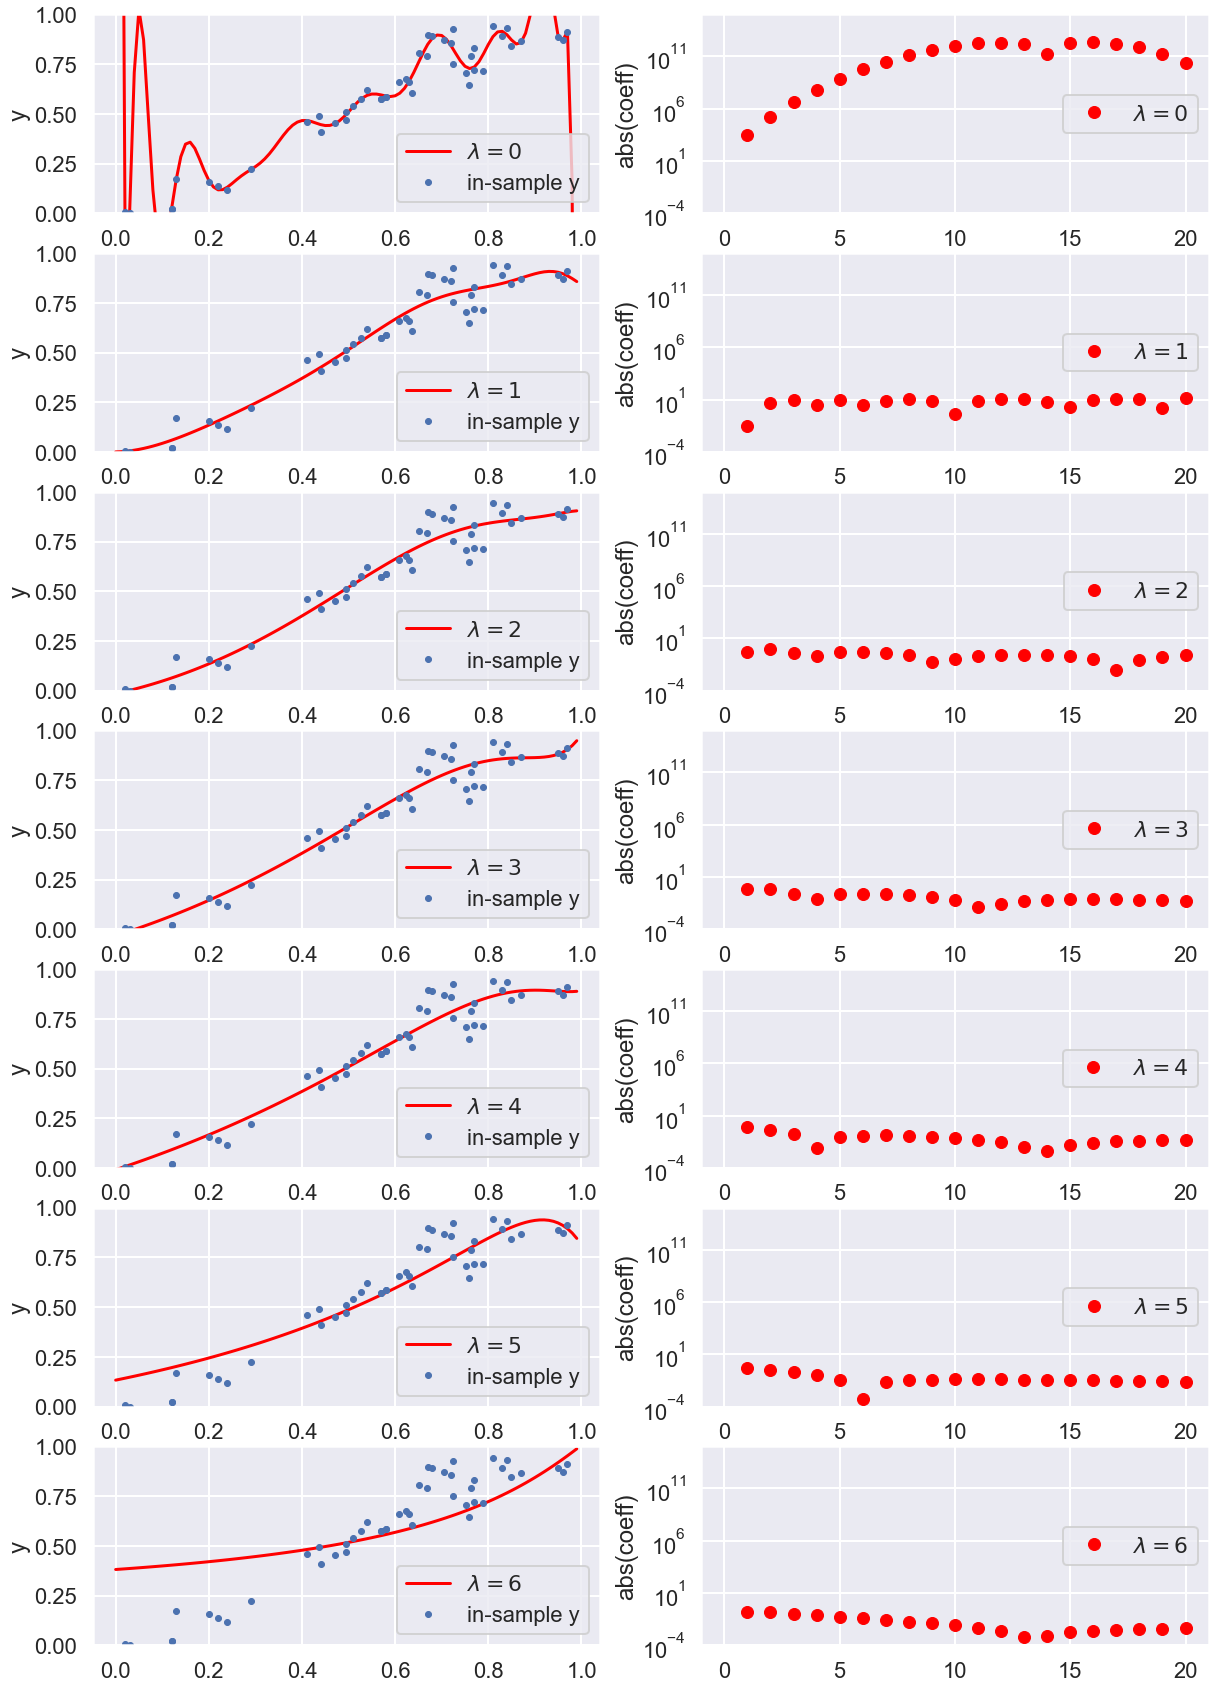

In [274]:
plt.figure(figsize=(20,30))

d = 20 # polynomial degree
lambdas = [0., 1e-6, 1e-3, 1e-2, 1e-1, 1, 10] # Various penalization parameters to try

# Our xtrain and xtest
xtrain = xtrain  # from previous sections
new_xtest = np.arange(0,1,0.01) # use this to predict

# Convert the train and test Xs to polynomials
xtrain_poly = PolynomialFeatures(d).fit_transform(xtrain.reshape(-1,1))
new_xtest_poly = PolynomialFeatures(d).fit_transform(new_xtest.reshape(-1,1))

# Build Ridge model and plot
i = lambdas[3]

for i, lam in enumerate(lambdas):    # this gives the index (i) and value in lambda (lam)
        
    # plot train data and predicted ones
    ridge_reg = Ridge(alpha = lam)  
    ridge_reg.fit(xtrain_poly, ytrain)  # fitting polynomial xtrain against ytrain
    ypred_ridge = ridge_reg.predict(new_xtest_poly)  # predict using the polynomial xtest
    
    plt.subplot(7, 2, 2*i+1)
    plt.plot(new_xtest, ypred_ridge, color = 'red', label = r"$\lambda = {}$".format(i))
    plt.plot(xtrain, ytrain, '.', label = 'in-sample y')
    plt.ylabel("y")
    plt.ylim(0,1)
    plt.legend(loc = 'lower right')
    
    # get coefficients of the polynomial Xs
    coef = ridge_reg.coef_.ravel()

    # plot the coefficients
    plt.subplot(7, 2, 2*i + 2)
    plt.semilogy(np.abs(coef), 'o', color = "red", label = r"$\lambda = {}$".format(i))
    plt.ylabel("abs(coeff)")
    plt.ylim(1e-4,1e+15)
    plt.legend(loc = 'right')


The left plot shows the predict values (line) against the train values (points). The right plot shows the values of each of the 20 coefficients (coz 20 degree poly) for each lambda value. 

For low lambda, all coefficients have relatively high absolute values and hence the predicted curve in more polynomial like. As lambda increases, the coefficients become zero and hence the predict plot becomes flatter and flatter.

## Cross validation
Two meta estimators - various parameters can be passed to get the optimal.... for example, can compare many models, varying lambdas, and custom k-folds
- ```GridSearchCV``` -  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- ```RandomizedSearchCV```

Note that the scoring gives a negative value for ```scoring = neg_mean_squared_error```. CV maximizes the negative of MSE, which is same as minimizing MSE. Read more on scoring here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter



In [318]:
from sklearn.model_selection import GridSearchCV

# define function for cross validation
def cv_optimize_ridge(x: np.ndarray, y: np.ndarray, list_of_lambdas: list, n_folds: int = 4):
    est = Ridge()
    parameters = {'alpha': list_of_lambdas}  # this has to be a dictonary for GridSearchCV
    gs = GridSearchCV(est, param_grid = parameters, cv = n_folds, scoring = "neg_mean_squared_error")
    gs.fit(x, y)
    return gs


In [326]:
lambs = [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
fitmodel = cv_optimize_ridge(xtrain_poly, ytrain, lambs, n_folds = 4)

In [327]:
fitmodel.cv_results_

{'mean_fit_time': array([0.00099725, 0.00074786, 0.00074792, 0.00074786, 0.00049895,
        0.        , 0.00049901, 0.00073612, 0.00074804, 0.00098467,
        0.00075644]),
 'std_fit_time': array([7.04948271e-04, 4.31776915e-04, 4.31811821e-04, 4.31777869e-04,
        4.98950545e-04, 0.00000000e+00, 4.99010542e-04, 4.25363385e-04,
        4.31880120e-04, 1.94227019e-05, 4.36928876e-04]),
 'mean_score_time': array([0.00024945, 0.00024962, 0.00024921, 0.00049865, 0.00074798,
        0.00099826, 0.0009985 , 0.        , 0.00024945, 0.        ,
        0.00024951]),
 'std_score_time': array([4.32052173e-04, 4.32361888e-04, 4.31639220e-04, 4.98652572e-04,
        4.31845795e-04, 2.97058451e-05, 7.07056978e-04, 0.00000000e+00,
        4.32052173e-04, 0.00000000e+00, 4.32155411e-04]),
 'param_alpha': masked_array(data=[1e-08, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001,
                    0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False, False, False, False,
     

In [328]:
print(fitmodel.best_estimator_, "\n")
print("Best Score = ", fitmodel.best_score_, "\n")  # score is negative MSE
print(fitmodel.best_params_)

Ridge(alpha=0.01) 

Best Score =  -0.005615420325487489 

{'alpha': 0.01}


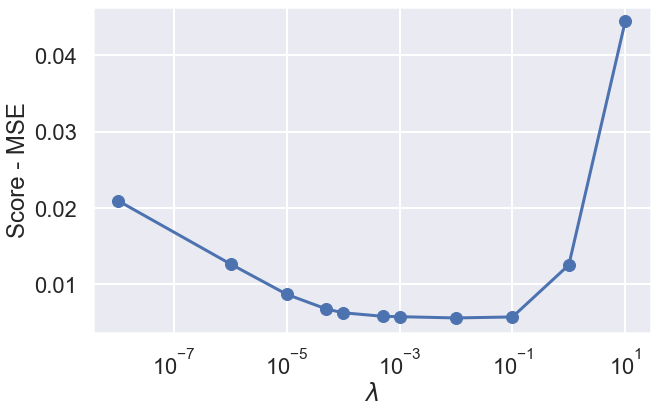

In [333]:
# Plot MSE vs alpha
# since the score output is negative MSE, I add a '-' before plotting

plt.figure(figsize=(10,6))
plt.plot(lambs, -fitmodel.cv_results_['mean_test_score'], 'o', ls= '-')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Score - MSE');


## Simpler Cross Validation
- ```cross_val_score``` - If you need the CV scores for a particular model/parameter
- Default scoring method is R2 and this is the output.... note that R2 can be negative

In [336]:
from sklearn.model_selection import cross_val_score

lr_object = Ridge(alpha = 0)
cross_val_score(lr_object, xtrain_poly, ytrain, cv = 5)

array([ 4.87048228e-01,  8.04797277e-01, -1.08389874e+00, -1.10267728e+03,
       -6.53351281e+08])

In [355]:
# can loop over various lambda values

for lambdas in [1e-8, 1e-4, 1e-2, 1.0, 10.0]:
    lr_object = Ridge(alpha = lambdas)
    scores = cross_val_score(lr_object, xtrain_poly, ytrain, cv = 5)
    print("Lambda ", lambdas, "\t R2 score", np.round(scores,2), "\t\t Mean", round(np.mean(scores),3))
    


Lambda  1e-08 	 R2 score [0.92 0.62 0.94 0.99 0.84] 		 Mean 0.861
Lambda  0.0001 	 R2 score [0.91 0.59 0.93 0.99 0.88] 		 Mean 0.86
Lambda  0.01 	 R2 score [0.92 0.6  0.93 0.99 0.88] 		 Mean 0.865
Lambda  1.0 	 R2 score [0.88 0.33 0.8  0.92 0.78] 		 Mean 0.744
Lambda  10.0 	 R2 score [ 0.58 -0.59  0.45  0.57 -0.06] 		 Mean 0.19


## Built in Cross Validation: $\color{blue}{\text{RidgeCV and LassoCV}}$